## Fairness Metrics on words

In [2]:
# Importing the required libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.model_selection import train_test_split
import re
import pickle
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

import os
import sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import matplotlib.pyplot as pyplot
from model.load_model import load_model_nn, predict_nn
model = load_model_nn()
# print(os.getcwd())

/home/me3eh/Bar_BoRoSa/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-09 11:06:02.439538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 11:06:02.804131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 11:06:02.804180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 11:06:02.805284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS w

In [3]:
# model = load_model_nn()
# predict_nn("text", model)
# # predict_nn("cyce", model, tokenizer, device)
# print(os.getcwd())


In [4]:
# # loading dataset
# # importing the dataset
first_data = pd.read_csv('./data/fake_and_real_data.csv')
# first_data.head()
second_data = pd.read_csv('./data/WELFake_Dataset.csv')
# print(os.getcwd())

In [5]:
# Checking for missing values

second_data.isnull().sum()

# Dropping the missing values
second_data = second_data.dropna()
# Checking for duplicates

second_data.duplicated().sum()

# Drop unnamed column
second_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# concatinating title and text
second_data['text'] = second_data['title'] + ' ' + second_data['text']
# Dropping the title column
second_data = second_data.drop(['title'], axis=1)



In [7]:
first_data.drop_duplicates(inplace=True)


first_data['label_t'] = 0


first_data.head()

,Text,label,label_t
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,0


In [8]:
# Preprocessing the data
first_data['label_t'] = (first_data['label'] != 'Fake').astype(int)
first_data = first_data.drop(['label'], axis=1)
first_data = first_data.rename(columns={'label_t': 'label'})
first_data = first_data.rename(columns={'Text': 'text'})
first_data.head()


,text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,0
1,U.S. conservative leader optimistic of common ...,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",1
3,Court Forces Ohio To Allow Millions Of Illega...,0
4,Democrats say Trump agrees to work on immigrat...,1


In [9]:
# Dropping the unnecessary columns
first_data.head()
# converting the text to lowercase
def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

first_data['text'] = first_data['text'].apply(preprocess)
second_data['text'] = second_data['text'].apply(preprocess)

In [10]:
first_data.head()
second_data.head()

concat_data = pd.concat([first_data, second_data], axis=0)
concat_data.head()


,text,label
0,top trump surrogate brutally stabs him in the ...,0
1,u s conservative leader optimistic of common g...,1
2,trump proposes u s tax overhaul stirs concerns...,1
3,court forces ohio to allow millions of illegal...,0
4,democrats say trump agrees to work on immigrat...,1


In [11]:
# is trump inclouded 

concat_data['does_contain_trump'] = concat_data['text'].apply(lambda x: 'trump' in x)

In [12]:
concat_data.head()

,text,label,does_contain_trump
0,top trump surrogate brutally stabs him in the ...,0,True
1,u s conservative leader optimistic of common g...,1,True
2,trump proposes u s tax overhaul stirs concerns...,1,True
3,court forces ohio to allow millions of illegal...,0,True
4,democrats say trump agrees to work on immigrat...,1,True


In [13]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['label'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    print(TN, "TN")
    print(FP, "FP")
    print(FN, "FN")
    print(TP, "TP")
    print(N, "N")
    ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predict_nned as positive
    
    return np.array([[ACC, TPR, FPR, FNR, PPP], [N, TN, FP, FN, TP]])

# Fairness with all values 

In [16]:
concat_data['text'].size //4

20350

In [27]:
# concat_data["text"][0].astype("string")
xd = pd.Series(concat_data['text'], dtype="string")

0        top trump surrogate brutally stabs him in the ...
1        u s conservative leader optimistic of common g...
2        trump proposes u s tax overhaul stirs concerns...
3        court forces ohio to allow millions of illegal...
4        democrats say trump agrees to work on immigrat...
                               ...                        
72129    russians steal research on trump in hack of u ...
72130    watch giuliani demands that democrats apologiz...
72131    migrants refuse to leave train at refugee camp...
72132    trump tussle gives unpopular mexican leader mu...
72133    goldman sachs endorses hillary clinton for pre...
Name: text, Length: 81402, dtype: string

In [49]:
concat_data["y_pred"] = concat_data["label"]

In [51]:

for y in range(20350):
  concat_data.iloc[y]["y_pred"] = [1 if predict_nn(concat_data.iloc[y]["text"], model) == "true" else 0]

1/1 [==============================] - 0s 71ms/step


/tmp/ipykernel_709221/2825691910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_data.iloc[y]["y_pred"] = [1 if predict_nn(concat_data.iloc[y]["text"], model) == "true" else 0]


1/1 [==============================] - 0s 99ms/step


In [ ]:

for y in range(20350, 20350*2):
  concat_data["y_pred"][y] = [1 if predict_nn(concat_data["text"][y], model) == "true" else 0]

In [17]:

for y in range(20350*2, 20350*3):
  concat_data["y_pred"][y] = [1 if predict_nn(concat_data["text"][y], model) == "true" else 0]

0
1
2
3
4
5
6
7
8
9


In [ ]:

for y in range(20350*3, concat_data.size):
  concat_data["y_pred"][y] = [1 if predict_nn(concat_data["text"][y], model) == "true" else 0]

In [ ]:
concat_data['label']

0        0
1        1
2        1
3        0
4        1
        ..
72129    0
72130    1
72131    0
72132    0
72133    1
Name: label, Length: 81402, dtype: int64

In [49]:
result = fairness_metrics(concat_data)
result

21645 TN
18383 FP
5419 FN
35955 TP
81402 N


array([[7.07599322e-01, 8.69024025e-01, 4.59253523e-01, 1.30975975e-01,
        6.67526596e-01],
       [8.14020000e+04, 2.16450000e+04, 1.83830000e+04, 5.41900000e+03,
        3.59550000e+04]])

# Fairness when having trump 

In [50]:
df_containing_trump = concat_data.loc[concat_data['does_contain_trump'] == True]
with_trump = fairness_metrics(df_containing_trump)
with_trump

9740 TN
10460 FP
4039 FN
17396 TP
41635 N


array([[6.51759337e-01, 8.11569862e-01, 5.17821782e-01, 1.88430138e-01,
        6.69052480e-01],
       [4.16350000e+04, 9.74000000e+03, 1.04600000e+04, 4.03900000e+03,
        1.73960000e+04]])

In [51]:
df_without_trump = concat_data.loc[concat_data['does_contain_trump'] == False]
without_trump = fairness_metrics(df_without_trump)
without_trump

11905 TN
7923 FP
1380 FN
18559 TP
39767 N


array([[7.66062313e-01, 9.30788906e-01, 3.99586443e-01, 6.92110938e-02,
        6.65929037e-01],
       [3.97670000e+04, 1.19050000e+04, 7.92300000e+03, 1.38000000e+03,
        1.85590000e+04]])

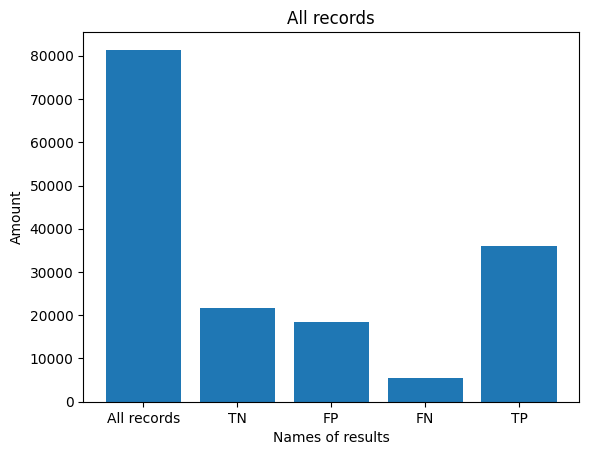

In [54]:
labels = ("All records", "TN", "FP", "FN", "TP")
index = (1, 2, 3, 4, 5)
sizes = [result[1][0], result[1][1], result[1][2], result[1][3], result[1][4]]
pyplot.bar(index, sizes, tick_label=labels)
pyplot.xlabel("Names of results")
pyplot.ylabel("Amount")
pyplot.title("All records")
pyplot.show()

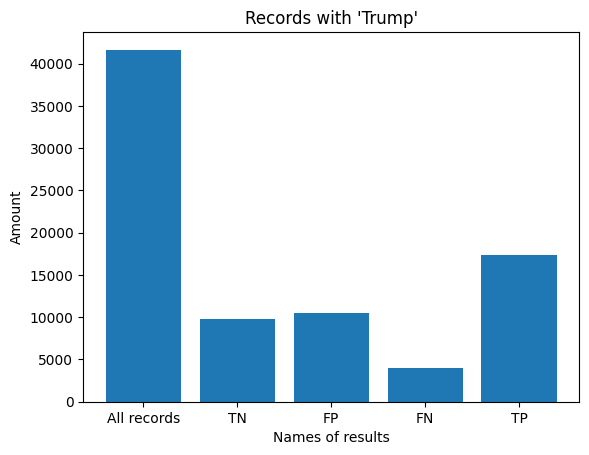

In [55]:
labels = ("All records", "TN", "FP", "FN", "TP")
index = (1, 2, 3, 4, 5)
sizes = [with_trump[1][0], with_trump[1][1], with_trump[1][2], with_trump[1][3], with_trump[1][4]]
pyplot.bar(index, sizes, tick_label=labels)
pyplot.xlabel("Names of results")
pyplot.ylabel("Amount")
pyplot.title("Records with 'Trump'")
pyplot.show()

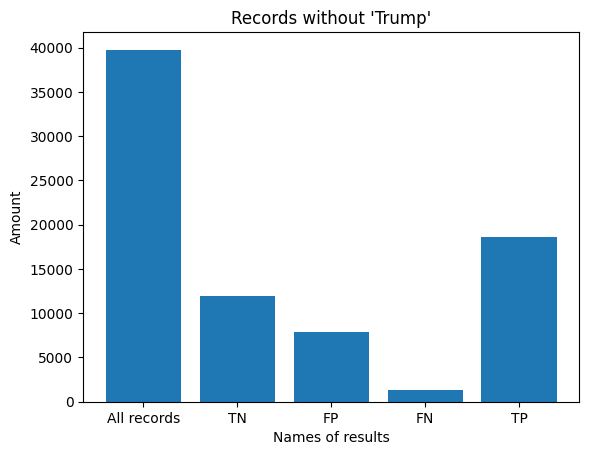

In [56]:
labels = ("All records", "TN", "FP", "FN", "TP")
index = (1, 2, 3, 4, 5)
sizes = [without_trump[1][0], without_trump[1][1], without_trump[1][2], without_trump[1][3], without_trump[1][4]]
pyplot.bar(index, sizes, tick_label=labels)
pyplot.xlabel("Names of results")
pyplot.ylabel("Amount")
pyplot.title("Records without 'Trump'")
pyplot.show()

Text(0.5, 1.0, 'All records')

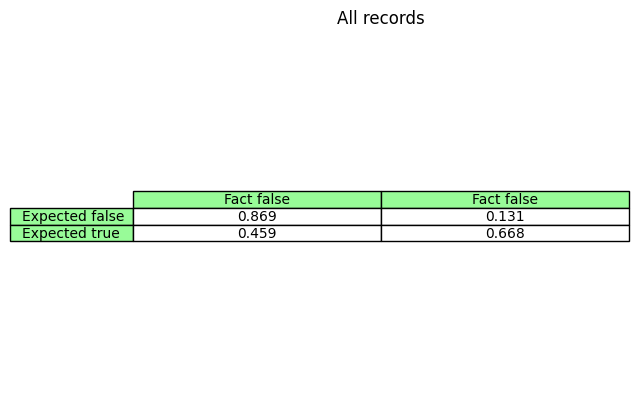

In [84]:
# "All records", "TN", "FP", "FN", "TP"

row_labels = ["Expected false", "Expected true"]
column_labels = ["Fact false", "Fact false"] 
val2 = ["{:02X}".format(10 * i) for i in range(10)] 
val3 = [[result[0][1], result[0][3]],[result[0][2], result[0][4]]] 
val3 = [[item.round(3) for item in item2] for item2 in val3]
fig, ax = pyplot.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = row_labels,  
    colLabels = column_labels, 
    rowColours =["palegreen"] * 2,  
    colColours =["palegreen"] * 2, 
    cellLoc ='center',  
    loc ='center')         
   
ax.set_title('All records') 

Text(0.5, 1.0, 'Records with trump')

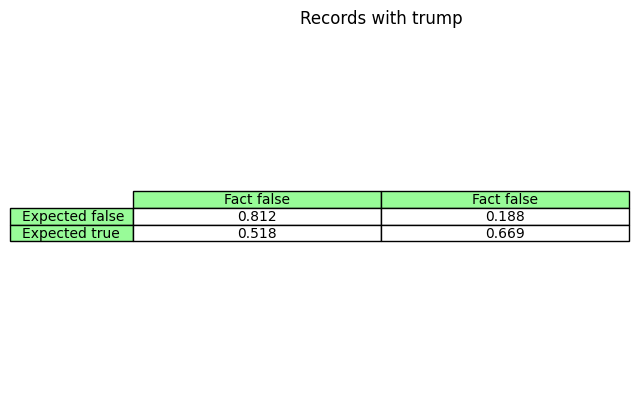

In [85]:
# ("All records", "TN", "FP", "FN", "TP")

row_labels = ["Expected false", "Expected true"]
column_labels = ["Fact false", "Fact false"] 
val2 = ["{:02X}".format(10 * i) for i in range(10)] 
val3 = [[with_trump[0][1], with_trump[0][3]],[with_trump[0][2], with_trump[0][4]]] 
val3 = [[item.round(3) for item in item2] for item2 in val3]

fig, ax = pyplot.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = row_labels,  
    colLabels = column_labels, 
    rowColours =["palegreen"] * 2,  
    colColours =["palegreen"] * 2, 
    cellLoc ='center',  
    loc ='center')         
   
ax.set_title('Records with trump') 

Text(0.5, 1.0, 'Records with trump')

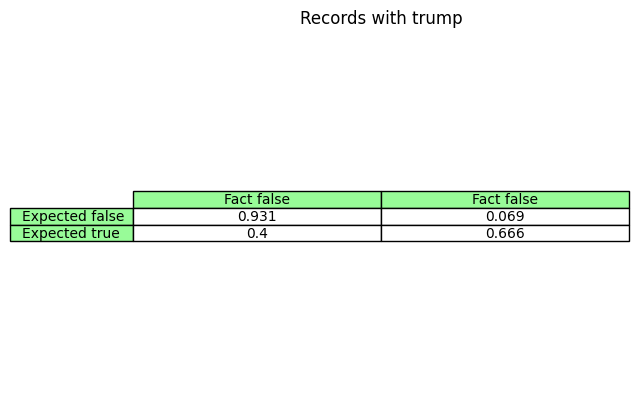

In [83]:
# ("All records", "TN", "FP", "FN", "TP")

row_labels = ["Expected false", "Expected true"]
column_labels = ["Fact false", "Fact false"] 
val2 = ["{:02X}".format(10 * i) for i in range(10)] 
val3 = [[without_trump[0][1], without_trump[0][3]],[without_trump[0][2], without_trump[0][4]]] 
val3 = [[item.round(3) for item in item2] for item2 in val3]

fig, ax = pyplot.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = row_labels,  
    colLabels = column_labels, 
    rowColours =["palegreen"] * 2,  
    colColours =["palegreen"] * 2, 
    cellLoc ='center',  
    loc ='center')         
   
ax.set_title('Records with trump') 